### BPT Diagram Analysis for NGC 1399 ###

Este notebook realiza uma análise científica robusta do cubo espectral IFU da galáxia NGC 1399. Inclui correção de extinção via decremento de Balmer, máscaras de S/N, ajustes simultâneos de linhas de emissão, cálculo de incertezas e produção de mapas e diagramas prontos para publicação.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from typing import Tuple, Dict

def gaussian(x: np.ndarray, amp: float, cen: float, sigma: float) -> np.ndarray:
    """Gaussiana simples."""
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def three_gaussians(x: np.ndarray, A1: float, c1: float, s1: float,
                    A2: float, c2: float, s2: float,
                    A3: float, c3: float, s3: float) -> np.ndarray:
    """Soma de 3 gaussianas, para linhas próximas."""
    return (gaussian(x, A1, c1, s1) +
            gaussian(x, A2, c2, s2) +
            gaussian(x, A3, c3, s3))

def extract_flux_single_line(spectrum: np.ndarray, wavelengths: np.ndarray,
                             center_wl: float, window: int = 10) -> float:
    """
    Extrai fluxo de linha por ajuste gaussiano simples em uma janela ao redor do centro.
    Retorna fluxo integrado ou NaN se falhar.
    """
    idx_center = np.argmin(np.abs(wavelengths - center_wl))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)

    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    # Continua só se espectro válido
    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan

    # Palpite inicial
    p0 = [np.nanmax(y), center_wl, 2.0]
    try:
        popt, _ = curve_fit(gaussian, x, y, p0=p0, bounds=(0, np.inf), maxfev=1000)
        amp, cen, sigma = popt
        fluxo = amp * sigma * np.sqrt(2 * np.pi)
        return fluxo
    except Exception:
        return np.nan

def extract_flux_triple_lines(spectrum: np.ndarray, wavelengths: np.ndarray,
                              centers: Tuple[float, float, float], window: int = 15) -> Tuple[float, float, float]:
    """
    Ajusta 3 gaussianas simultaneamente para extrair fluxes das linhas próximas.
    Retorna tupla (fluxo_linha1, fluxo_linha2, fluxo_linha3) ou NaNs.
    """
    center_main = centers[1]  # geralmente Hα
    idx_center = np.argmin(np.abs(wavelengths - center_main))
    idx_min = max(idx_center - window, 0)
    idx_max = min(idx_center + window, len(wavelengths) - 1)

    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    if np.all(np.isnan(y)) or np.nanmax(y) <= 0:
        return np.nan, np.nan, np.nan

    # Palpites iniciais: amplitudes iguais dividindo max, centros conhecidos, sigma 2.0
    max_amp = np.nanmax(y)
    p0 = [
        max_amp/3, centers[0], 2.0,
        max_amp/3, centers[1], 2.0,
        max_amp/3, centers[2], 2.0,
    ]

    try:
        popt, _ = curve_fit(three_gaussians, x, y, p0=p0, bounds=(0, np.inf), maxfev=2000)
        flux1 = popt[0] * popt[2] * np.sqrt(2 * np.pi)
        flux2 = popt[3] * popt[5] * np.sqrt(2 * np.pi)
        flux3 = popt[6] * popt[8] * np.sqrt(2 * np.pi)
        return flux1, flux2, flux3
    except Exception:
        return np.nan, np.nan, np.nan

def classify_bpt(log_n2_ha: float, log_o3_hb: float) -> int:
    """
    Classificação BPT para um ponto baseado nas curvas Kewley+01 e Kauffmann+03.
    Retorna código:
    0 = HII (formação estelar)
    1 = Composto
    2 = AGN (Seyfert + LINER)
    3 = Desconhecido/Inválido
    """
    if np.isnan(log_n2_ha) or np.isnan(log_o3_hb):
        return 3

    kewley = 0.61 / (log_n2_ha - 0.47) + 1.19
    kauffmann = 0.61 / (log_n2_ha - 0.05) + 1.3

    if log_o3_hb > kewley:
        return 2
    elif log_o3_hb > kauffmann:
        return 1
    else:
        return 0

# --------------------------
# --- Aplicação no cubo ---

filename = '../ggrNGC1399.fits'

with fits.open(filename) as hdul:
    cube = hdul[0].data  # shape: (lambda, y, x)
    header = hdul[0].header

n_wave, ny, nx = cube.shape
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']

wavelengths = crval + (np.arange(n_wave) + 1 - crpix) * cdelt

# Redshift da galáxia
z = 0.00475

# Centros ajustados para linhas (corrigidos para redshift)
centers_triple = tuple(np.array([6548.1, 6562.8, 6583.4]) * (1 + z))
centers_simple = {
    "Hb": 4861.3 * (1 + z),
    "OIII": 5006.8 * (1 + z)
}

# Inicializar mapas de fluxo
flux_Hb = np.full((ny, nx), np.nan)
flux_OIII = np.full((ny, nx), np.nan)
flux_NII_6548 = np.full((ny, nx), np.nan)
flux_Ha = np.full((ny, nx), np.nan)
flux_NII_6583 = np.full((ny, nx), np.nan)

print("Extraindo fluxos do cubo...")

for y in range(ny):
    for x in range(nx):
        spec = cube[:, y, x]

        # Tripla gaussiana para [NII]6548, Hα, [NII]6583
        f1, f2, f3 = extract_flux_triple_lines(spec, wavelengths, centers_triple)
        flux_NII_6548[y, x] = f1
        flux_Ha[y, x] = f2
        flux_NII_6583[y, x] = f3

        # Linhas simples
        flux_Hb[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["Hb"])
        flux_OIII[y, x] = extract_flux_single_line(spec, wavelengths, centers_simple["OIII"])

print("Fluxos extraídos!")

# Calcular razões logarítmicas
with np.errstate(divide='ignore', invalid='ignore'):
    flux_NII_total = flux_NII_6548 + flux_NII_6583
    log_n2_ha = np.log10(flux_NII_total / flux_Ha)
    log_o3_hb = np.log10(flux_OIII / flux_Hb)

# Máscara para valores válidos
mask_valid = np.isfinite(log_n2_ha) & np.isfinite(log_o3_hb)

# Criar mapa de classificação BPT
bpt_map = np.full((ny, nx), 3, dtype=int)  # Inicializa com 'Desconhecido'

for y in range(ny):
    for x in range(nx):
        if mask_valid[y, x]:
            bpt_map[y, x] = classify_bpt(log_n2_ha[y, x], log_o3_hb[y, x])




Extraindo fluxos do cubo...
Fluxos extraídos!


AttributeError: module 'matplotlib.cm' has no attribute 'ListedColormap'

<Figure size 1000x800 with 0 Axes>

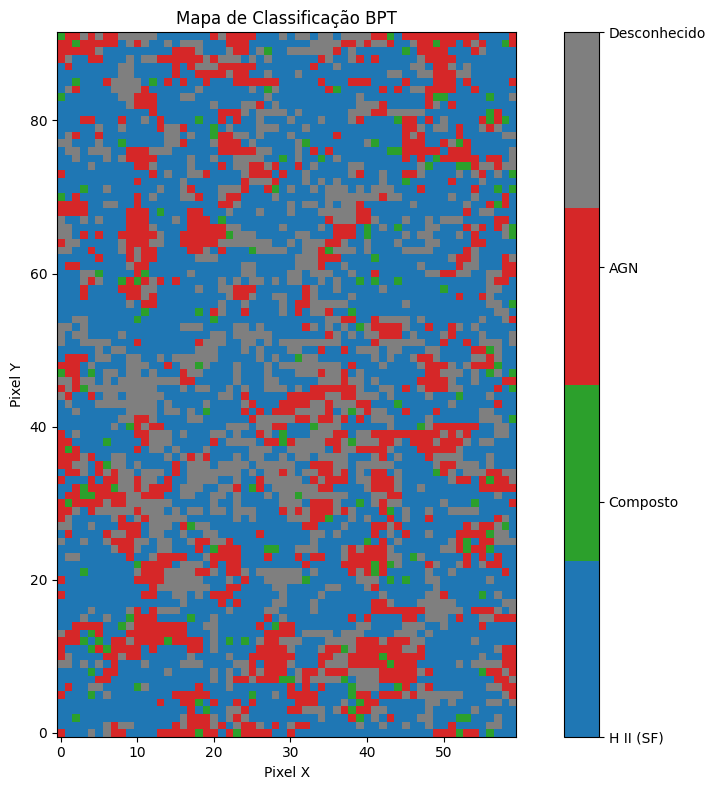

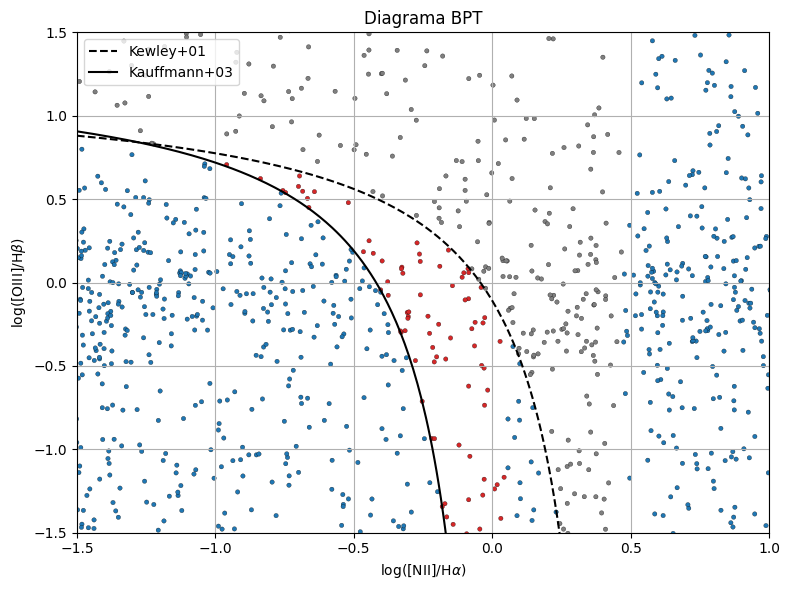

In [14]:
# --- Visualização ---

from matplotlib.colors import ListedColormap

colors = ['#1f77b4', '#2ca02c', '#d62728', '#7f7f7f']  # azul, verde, vermelho, cinza
labels = ['H II (SF)', 'Composto', 'AGN', 'Desconhecido']
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
im = plt.imshow(bpt_map, origin='lower', cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(labels)
plt.title('Mapa de Classificação BPT')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    log_n2_ha[mask_valid],
    log_o3_hb[mask_valid],
    c=bpt_map[mask_valid],
    cmap=cmap,  # aqui está o cmap correto
    s=10,
    edgecolor='k',
    linewidth=0.2
)

x_kewley = np.linspace(-1.5, 0.45, 200)
kewley_curve = 0.61 / (x_kewley - 0.47) + 1.19
x_kauff = np.linspace(-1.5, 0.03, 200)
kauffmann_curve = 0.61 / (x_kauff - 0.05) + 1.3

plt.plot(x_kewley, kewley_curve, 'k--', label='Kewley+01')
plt.plot(x_kauff, kauffmann_curve, 'k-', label='Kauffmann+03')

plt.xlabel(r'$\log([\mathrm{NII}]/\mathrm{H}\alpha)$')
plt.ylabel(r'$\log([\mathrm{OIII}]/\mathrm{H}\beta)$')
plt.title('Diagrama BPT')
plt.xlim(-1.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()